# Лабораторная работа по Relevance Vector Regression
В рамках этой лабораторной работы необходимо:
- Имплементировать Relevance Vector Regression
- Применить на синетическом датасете (восстановление полинома), сравнить с Lasso из sklearn и гребневой регрессией
- Применить на данных sinc с RBF признаками, визуализировать "релевантные вектора", сравнить с Support Vector Regression и Lasso
- Сделать выводы

In [135]:
import numpy as np
from matplotlib import pyplot as plt
from __future__ import print_function
from time import time

%matplotlib inline
np.random.seed(123)

def l2_error(X, t, w):
    return np.sum((X.dot(w.ravel()) - t) ** 2)

## Имплементация Relevance Vector Regression

Здесь необходимо реализовать три функции:

1. `get_w_sigma(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и возвращает параметры апостериорного распределения mu, sigma
2. `update_alpha_beta(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и делает один шаг итерационной процедуры для обновления гиперпараметров (было на лекции)
3. `fit_rvr(X, t, max_iters)`, которая принимает датасет (X, t) и максимальное количество итераций и возвращает обученные гиперпараметры и параметры апостериорного распределения на веса модели

На что стоит обратить внимание:

1. Результаты дорогостоящих операций типа перемножения одних и тех же матриц нужно кешировать и переиспользовать
2. $\alpha$-ы для нерелевантных объектов должны принять значение `np.inf`, а соответствующие веса и их дисперсии должны иметь значение 0
3. Бесконечности и нули из предыдущего пункта должны обрабатываться корректно, без NaN-ов и warning-ов
4. Матрицу с бесконечными элементами на диагонали можно обращать более эффективно (достаточно обратить подматрицу)

In [136]:
from tqdm.notebook import tqdm

def get_w_sigma(X, t, alpha, beta, xTx, xTt):
    """Calculate the mean and the covariance matrix
       of the posterior distribution"""
    not_inf_inds = np.isfinite(alpha)

    inv_sigma = beta * xTx + np.diag(alpha)
    inv_sigma = np.linalg.inv(inv_sigma[not_inf_inds][:, not_inf_inds])
    sigma = np.zeros((X.shape[1], X.shape[1]))
    sigma[np.ix_(not_inf_inds, not_inf_inds)] = inv_sigma
    w = sigma.dot(beta * xTt)

    return w, sigma


def update_alpha_beta(X, t, alpha, beta, xTx, xTt):
    """Update the hyperperemeters to increase evidence"""
    w, sigma = get_w_sigma(X, t, alpha, beta, xTx, xTt)
    not_inf_inds = np.isfinite(alpha)
    tol = 1e-10

    gamma = 1 - alpha[not_inf_inds] * np.diagonal(sigma)[not_inf_inds]
    beta_new = (X.shape[0] - gamma.sum()) / np.sum((t - X.dot(w)) ** 2)

    alpha_new = np.full(alpha.shape, np.inf)
    non_zero_w = np.abs(w[not_inf_inds] ** 2) > tol

    alpha_new[not_inf_inds] = np.where(
        non_zero_w,
        gamma / (w[not_inf_inds] ** 2),
        np.inf
    )

    return alpha_new, beta_new


def fit_rvr(X, t, max_iter=10000):
    """Train the Relevance Vector Regression model"""

    alpha = np.full((X.shape[1],), 1e-6)
    beta = 1.0
    xTx = X.T.dot(X)
    xTt = X.T.dot(t)

    for i in tqdm(range(max_iter)):
        old_alpha, old_beta = alpha, beta
        alpha, beta = update_alpha_beta(X, t, alpha, beta, xTx, xTt)

    w, sigma = get_w_sigma(X, t, alpha, beta, xTx, xTt)

    return w, sigma, alpha, beta

## Восстановление полинома

Здесь решается модельная задача: зашумленным полиномом третьей степени сгенерированы данные для задачи регрессии. Нужно на этих данных обучить многочлен степени, не превышающей 20. Предлагается сравнить три модели: гребневую регрессию, L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных признаков.

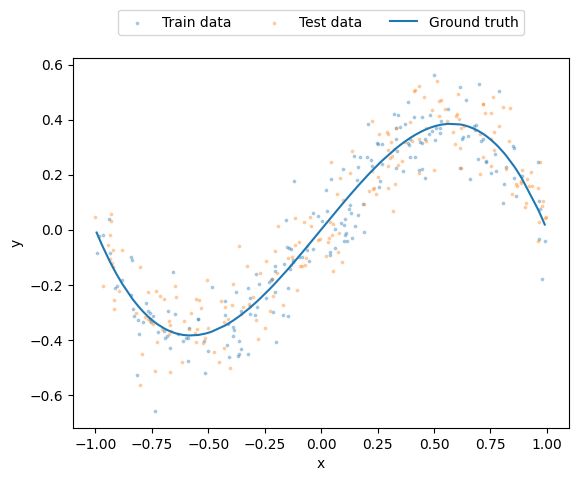

In [137]:
# Data generation

def gen_batch(n, w, beta):
    d = len(w)
    X = np.random.uniform(-1, 1, (n, 1))
    X = np.sort(X, axis=0)
    X = np.hstack([X ** i for i in range(d)])
    t = X.dot(w) + np.random.normal(size=n) / beta ** 0.5
    return X, t

n = 200
d = 21
w_true = np.zeros(d)
w_true[1] = 1
w_true[3] = -1
beta_true = 100

X_train, t_train = gen_batch(n, w_true, beta_true)
X_test, t_test = gen_batch(n, w_true, beta_true)

# Visualization
fig, ax = plt.subplots()
ax.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
ax.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

In [138]:
# Relevance Vector Regression
pol_rvr_time = time()
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train)
print('Training_time: {:.3f}'.format(time() - pol_rvr_time))

  0%|          | 0/10000 [00:00<?, ?it/s]

Training_time: 2.188


In [139]:
# Ridge Regression with Cross-Validation
from sklearn.linear_model import RidgeCV
pol_ridge_time = time()
ridge = RidgeCV(cv=20, alphas=10.**np.linspace(-6, 3, 100),
                fit_intercept=False).fit(X_train, t_train)
print('Training_time: {:.3f}'.format(time() - pol_ridge_time))
w_ridge = ridge.coef_

Training_time: 3.939


In [140]:
# Lasso Regression with Cross-Validation
from sklearn.linear_model import LassoCV, Lasso
pol_lasso_time = time()
lasso = LassoCV(cv=5, alphas=10.**np.linspace(-6, 3, 100),
                fit_intercept=False, max_iter=10000000).fit(X_train, t_train)
print('Training_time: {:.3f}'.format(time() - pol_lasso_time))
w_lasso = lasso.coef_

Training_time: 9.686


Relevance Vector Regression
Features remaining: 3 / 21
Train error: 0.009052796709304888
Test error:  0.00979346412659534
--------------------------------------------------
Ridge Regression
Features remaining: NA (no sparsity)
Train error: 0.009095034553223615
Test error:  0.00996144205308367
--------------------------------------------------
Lasso Regression
Features remaining: 9 / 21
Train error: 0.008878963547469502
Test error:  0.010139505424318273


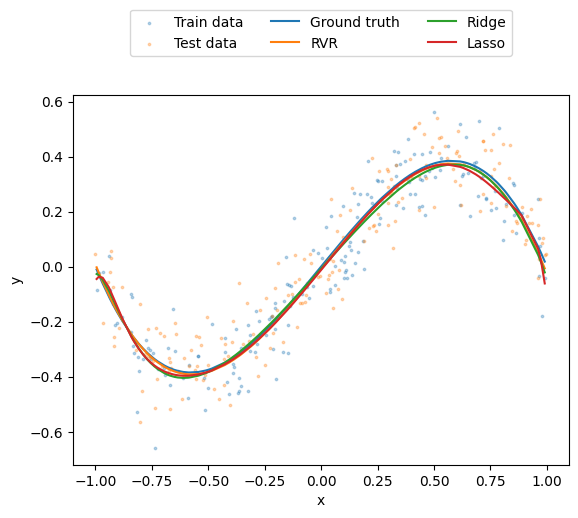

In [141]:
# Comparison
print('Relevance Vector Regression')
print('Features remaining:', np.sum(alpha_rvr < 1e8), '/', d)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-'*50)
print('Ridge Regression')
print('Features remaining: NA (no sparsity)')
print('Train error:', l2_error(X_train, t_train, w_ridge) / n)
print('Test error: ', l2_error(X_test, t_test, w_ridge) / n)
print('-'*50)
print('Lasso Regression')
print('Features remaining:', np.sum(np.abs(w_lasso) > 1e-20), '/', d)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)

fig, ax = plt.subplots()
ax.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
ax.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')
ax.plot(X_train[:, 1], X_train.dot(w_rvr), label='RVR')
ax.plot(X_train[:, 1], X_train.dot(w_ridge), label='Ridge')
ax.plot(X_train[:, 1], X_train.dot(w_lasso), label='Lasso')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

**Выводы**

1. Во-первых, RVR показывает лучший результат среди применённых методов с точки зрения ошибки на тесте. Lasso хоть и получилось обучить на меньшую ошибку при обучении, но количество релевантных признаков у RVR в 3 раза меньше, чем у Lasso.
2. Обучение у RVR достаточно быстрое, и при этом результат хорошо описывает исходную зависимость.
3. Легко видеть, что метод RVR также хорошо использовать для отбора информативных признаков, что можно заметить по итоговому качеству обученной модели и количеству отобранных признаков (3 из 21).



## Регрессия с RBF-признаками

Здесь решается другая модельная задача: необходимо восстановить зашумленную функцию `sinc(x)`. Предлагается применить kernel trick с RBF-ядром (можно использовать функцию `sklearn.metrics.pairwise.rbf_kernel`), обучить три модели: SVM-регрессию (SVR), L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных опорных / релевантных объектов.

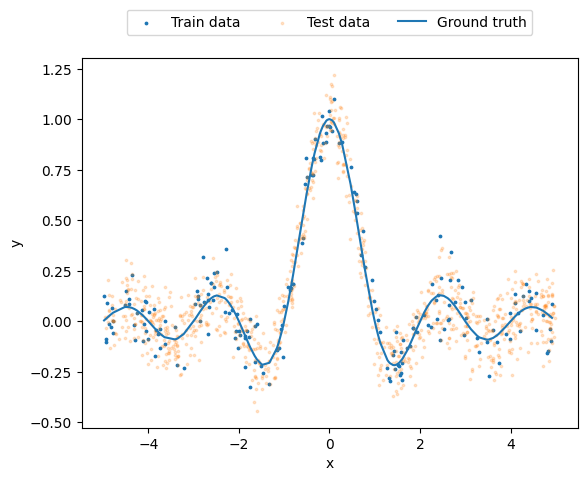

In [142]:
# Data generation
from sklearn.metrics.pairwise import rbf_kernel

def gen_batch(n, beta):
    points = np.random.uniform(-5, 5, n)
    points = np.sort(points)
    t = np.sinc(points) + np.random.normal(size=n) / beta ** 0.5
    return points, t

n = 200
n_test = 1000
d = n + 1
beta_true = 100

points_train, t_train = gen_batch(n, beta_true)
points_test, t_test = gen_batch(n_test, beta_true)

# RBF-transform
X_train = rbf_kernel(points_train.reshape(-1, 1))
X_test = rbf_kernel(points_test.reshape(-1, 1), points_train.reshape(-1, 1))

# Constant feature
X_train = np.hstack((np.ones((n, 1)), X_train))
X_test = np.hstack((np.ones((n_test, 1)), X_test))

# Visualization
fig, ax = plt.subplots()
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=1)
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.2)
ax.plot(points_train, np.sinc(points_train), label='Ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

In [143]:
# Relevance Vector Regression
sinc_rvr_time = time()
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train)
print('Training_time: {:.3f}'.format(time() - sinc_rvr_time))

  0%|          | 0/10000 [00:00<?, ?it/s]

Training_time: 5.366


In [144]:
# Lasso Regression with Cross-Validation
from sklearn.linear_model import LassoCV
sinc_lasso_time = time()
lasso = LassoCV(cv=10, alphas=10.**np.linspace(-5, 1, 20),
                fit_intercept=False, max_iter=100000, tol=1e-2, n_jobs=10).fit(X_train, t_train)
print('Training_time: {:.3f}'.format(time() - sinc_lasso_time))
w_lasso = lasso.coef_

Training_time: 1.639


In [145]:
# Support Vector Regression
from sklearn.svm import SVR
sinc_svr_time = time()
svr = SVR(gamma=1, tol=1e-6, C=1).fit(points_train.reshape(-1, 1), t_train)
print('Training_time: {:.3f}'.format(time() - sinc_svr_time))

Training_time: 0.006


Relevance Vector Regression
Objects remaining: 12 / 200
Train error: 0.007978492615095907
Test error:  0.05393679623521772
--------------------------------------------------
Lasso Regression
Objects remaining: 63 / 200
Train error: 0.009447935993241242
Test error:  0.057053745050616646
--------------------------------------------------
Support Vector Regression
Objects remaining: 59 / 200
Train error: 0.008025457213352068
Test error:  0.05380997349742385


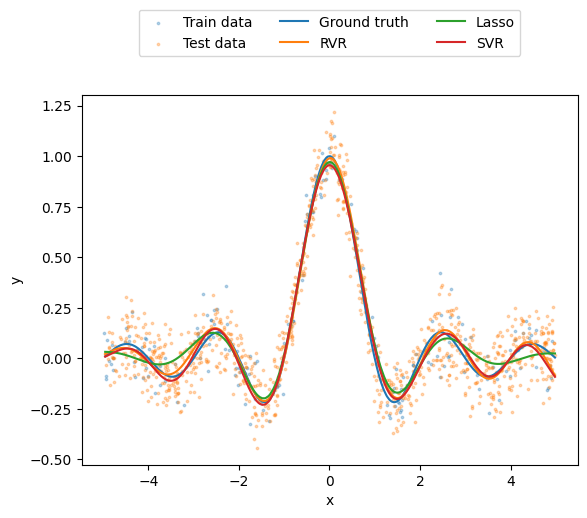

In [146]:
# Comparison
print('Relevance Vector Regression')
print('Objects remaining:', np.sum(alpha_rvr[1:] < 1e8), '/', n)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-'*50)
print('Lasso Regression')
print('Objects remaining:', np.sum(np.abs(w_lasso[1:]) > 1e-20), '/', n)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)
print('-'*50)
print('Support Vector Regression')
print('Objects remaining:', len(svr.support_), '/', n)
print('Train error:', np.sum((svr.predict(points_train.reshape(-1, 1)) - t_train) ** 2) / n)
print('Test error: ', np.sum((svr.predict(points_test.reshape(-1, 1)) - t_test) ** 2) / n)

fig, ax = plt.subplots()
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
ax.plot(points_test, np.sinc(points_test), label='Ground truth')
ax.plot(points_test, X_test.dot(w_rvr), label='RVR')
ax.plot(points_test, X_test.dot(w_lasso), label='Lasso')
ax.plot(points_test, svr.predict(points_test.reshape(-1, 1)), label='SVR')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

### Визуализация релевантных объектов для RVR

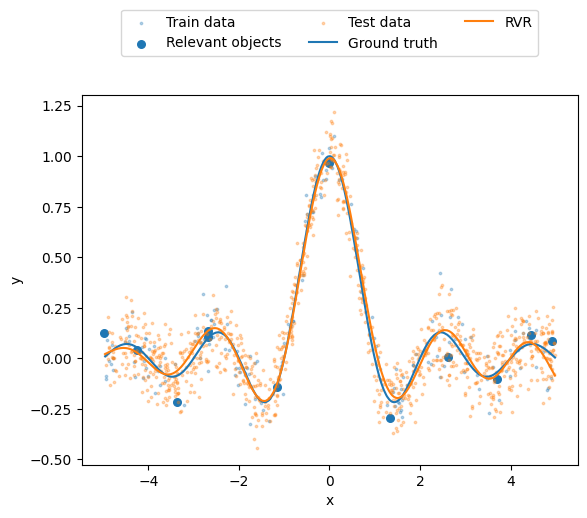

In [147]:
relevant = alpha_rvr[1:] < 1e8
fig, ax = plt.subplots()
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(points_train[relevant], t_train[relevant], c='tab:blue', s=30, label='Relevant objects')
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
ax.plot(points_test, np.sinc(points_test), label='Ground truth')
ax.plot(points_test, X_test.dot(w_rvr), label='RVR')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

Выводы

1. RVR обучается дольше при использовании kernel trick
2. Качество обучения RVR опять лучше чем у других методов (Lasso и SVR), за исключением ошибки на тесте у SVR, которая оказалась чуть меньше, чем у RVR
3. Значительный отбор полезных и релевантных признаков и объектов. Метод RVR отобрал 12 самых важных из 200, в отличие от других методов, в которых осталось почти в 4 раза больше

## Выводы
В этом поле опишите свои наблюдения и сформулируйте свои выводы

Метод RVR является достаточно элегантным, простым в обучении и эффективным методом для задачи регрессии. Он действительно помогает очень хорошо отбирать полезные признаки, в разы лучше, чем у других методов. Обучается метод также достаточно быстро, однако при большом количестве данных (в нашем примере - при kernel trick) обучение проходит в разы дольше в силу постоянного обращения матрицы.  